In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Measuring the Applicants Gap in 2017

Let's do something really simple, but in a really effective manner. That thing is: measuring the applicants gaps in 2017.

![image of actual amount of applicants vs. expected amont of applicants][1]

Each year, 8th graders from all over New York City take a test called SHSAT to see who will get access to the famous Specialized High Schools (SPHS). These Specialized High Schools are schools that receive great attention and provide a estimulating environment for students who have the desire to learn.

Problem is, students that receive offers from SPHS are usually from a very specific demographic. Usually white or asian guys, mostly from the upper class, and from very small number of schools. This demographic characteristics are tightly linked to academic performance<sup><a href="https://steinhardt.nyu.edu/scmsAdmin/media/users/sg158/PDFs/Pathways_to_elite_education/WorkingPaper_PathwaystoAnEliteEducation.pdf">1</a></sup>, showing deeply ingrained questions that cannot be solved in a simple manner.

What we can do, however, is target certain schools. PASSNYC is associated with a lot of organizations that provides services such as:

- Test preparation
- Afterschool activities
- Mentoring
- Community and student groups
- Etc

But, what schools to target? Simple, we choose those with the biggest gap between the actual number of applicants and the number of applicants that would be expected given the school characteristics.

... 

Okay, it's not as simple as this. But, what we do here can provide invaluable information in the process of choosing which schools to intervene. This kernel is aimed at providing a simple yet effective model with which the gap can be estimated.

[1]: ../data/keep/the-gap.png

# Little glimpse at the data

The crucial information for us is the amount of SHSAT applicants from each school. It can be found [here][1], and only includes students from 2017.

Then, we assembled lots of data related to the students and the schools they attend. Information includes:

- Percentage of each ethnicity in each school
- Percentage of students with disabilities in each school
- The Economic Need Index of each school (indicates the poverty of the students)
- The distribution of grades for each school at the NYS Common Core tests<sup>1</sup>
- Some other things

Below, you can see what I'm talking about more clearly.

<sub>1: The grades a student can get are 1, 2, 3 or 4. We have the percentage of students in each grade and also the mean scale score of each school. The mean scale score of each school has been standardized, for an easier interpretation.</sub>

[1]: https://data.cityofnewyork.us/Education/2017-2018-SHSAT-Admissions-Test-Offers-By-Sending-/vsgi-eeb5/

In [3]:
# import data
df = pd.read_pickle('../data/process/schools2017.pkl')
print(df.shape[0], "schools")

# drop schools with missing test data
df = df[df.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]
print(df.shape[0], "schools after dropping missing test data")

# drop schools with missing attendance data
df = df[df['Percent of Students Chronically Absent'].notnull()]
print(df.shape[0], "schools after dropping missing attendance data")

# schools with 0-5 SHSAT testers have this value set to NaN
applicantsok = df['# SHSAT Testers'].notnull()

# show head of data
f2_columns = ['Latitude', 'Longitude', 'Economic Need Index',
              'Mean Scale Score - ELA', 'Mean Scale Score - Math']
pct_columns = [c for c in df.columns if c.startswith('Percent')]
pct_columns += [c for c in df.columns if c.startswith('%')]
df.head().style. \
    format('{:.2f}', subset=f2_columns). \
    format('{:.1%}', subset=pct_columns)

594 schools
588 schools after dropping missing test data
578 schools after dropping missing attendance data


,School Name,Charter School?,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,# SHSAT Testers,# SHSAT Offers,% SHSAT Testers,% SHSAT Offers
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,
01M034,P.S. 034 Franklin D. Roosevelt,0,manhattan,40.73,-73.98,5.3%,29.7%,61.4%,3.0%,0.6%,8.0%,38.0%,30.5%,0.87,-0.11,59.3%,22.2%,1.9%,-0.70,34.6%,13.5%,0.0%,58,6,nan,10.3%,nan%
01M140,P.S. 140 Nathan Straus,0,manhattan,40.72,-73.98,4.4%,12.1%,79.4%,3.0%,1.1%,12.4%,33.8%,39.5%,0.85,-0.16,60.0%,21.8%,1.8%,-0.45,38.6%,14.0%,0.0%,67,6,nan,9.0%,nan%
01M184,P.S. 184m Shuang Wen,0,manhattan,40.71,-73.99,69.7%,4.4%,12.4%,8.5%,5.0%,17.1%,19.2%,4.1%,0.56,1.71,21.0%,39.5%,34.6%,1.78,16.9%,28.9%,44.6%,88,67,23,76.1%,26.1%
01M188,P.S. 188 The Island School,0,manhattan,40.72,-73.98,1.9%,32.0%,62.5%,3.6%,0.0%,15.4%,33.2%,36.9%,0.94,-0.26,45.1%,15.7%,2.0%,-0.30,46.2%,21.2%,0.0%,59,nan,nan,nan%,nan%
01M301,"Technology, Arts, and Sciences Studio",0,manhattan,40.73,-73.98,8.7%,32.3%,49.6%,5.5%,3.9%,4.7%,44.1%,38.2%,0.75,0.25,46.3%,31.7%,4.9%,-0.60,36.6%,12.2%,2.4%,51,11,nan,21.6%,nan%


# Principal Component Analysis

We expect our data to have a lot of collinearity. That is, we expect variables to be very related to one another. This might cause problems when fitting a model.

To alleviate this problem, we use a technique called Principal Component Analysis (abbreviated PCA). This technique reduces the amount of features to an arbitrary number (that we can specify). The features generated are those that can best explain the original variables, making it a really nice approach.

# Cross-validation

To choose the best amount of features, we will use cross-validation. It is a technique for splitting the dataset into training and test sets multiple times, making use of the data in an efficient way.

The cross-validation method used is a [repeated k-fold][1]. Explaining it is out of the scope of this kernel, but, let's just say it is one of the most recommended methods. It requires a lot of iterations, but, since our dataset is not big (comparing to today's "big data"), this is no problem.

We used the parameters `n_splits=10` and `n_repeats=20`.

[1]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold

To choose the best number of features, we use both the Median Absolute Error and the Mean Squared Error. The first metric indicates how well the model is fitting overall, ignoring the weight of outliers<sup>1</sup>. The second metric, in contrast, is more sensitive to outliers, giving bigger importance to bigger errors.

Based on the plots, we can see that 8 principal components is a good choice. It has the lowest Median Absolute Error and still keeps the Mean Squared Error at control.

This is gonna be the value used.

<sub>1: A better explanation of how we should treat outliers is gonna be made in the modeling section</sub>

# Fitting the model

We will use a very simple model. There are two gists, though:

1. We are using it to *measure the application gap* in each school

   This may seem not relevant to the model choice, but it is very, very important.

   Say, of these two lines, which one do you think works best when predicting the gap between what is expected and what really occured?

   ![](../data/keep/regression1.png)
   ![](../data/keep/regression2.png)

  I'd say the second one, as it gives a nicer representation to points that are close to expected, and, predicts a big gap for points that are surely off.

  The first line was generated using a standard regression and the second one was generated using a robust regression (we say robust because it is *robust to outliers*). The model that I'm gonna use is a robust one.

2. The outcomes we are trying to predict are *probabilities*

   Okay, they are actually the percentage of applicants at each school. But, can't we assume that this is the probability of each student at a certain school applying for the SHSAT? Although being a simplification, this is what we are gonna work upon. Being a model to predict probabilities, logistic regression is usually a better choice than linear regression. So, we use logistic regression<sup>1</sup>.
   
---

In the end, the model we are gonna is a *robust logistic regression*<sup>2</sup>. In the next cells I will fit it, predict with it and display some results.

<sub>
    1: I know, my logic is a little flawed. I will try improving on this area later.<br>
    2: Actually, a robust linear regression with logits as outputs (transforming the model into a logistic regression)
</sub>

In [4]:
base_df = df[[  # explanatory variables
    'Charter School?',
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent Other',
    'Percent English Language Learners',
    'Percent Students with Disabilities',
    'Economic Need Index',
    'Percent of Students Chronically Absent',
    
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]

# transform the variables (apply the PCA)
n_components = 8
pca = PCA(n_components)
transformed = pca.fit_transform(base_df)
transformed = pd.DataFrame(transformed, index=base_df.index, columns=["PC{}".format(i+1) for i in range(n_components)])

# add a constant column (needed for our model with statsmodels)
inputs = transformed
inputs.insert(0, 'Constant', 1.0)
inputs.head()

,Constant,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
DBN,,,,,,,,,
01M034,1.0,-1.034147,-0.154674,0.041446,-0.121625,-0.140503,-0.022917,0.085729,-0.115563
01M140,1.0,-0.897518,-0.239089,0.340835,-0.080362,-0.185529,-0.040524,0.040417,-0.171720
01M184,1.0,2.194289,-0.332091,0.116154,0.360031,0.176916,0.095390,0.405709,0.041748
01M188,1.0,-0.854424,-0.098884,0.270485,0.179960,-0.267610,0.021405,0.023005,-0.074863
01M301,1.0,-0.685030,-0.173149,-0.172276,-0.223276,-0.072429,-0.045875,0.085162,-0.078991


In [5]:
# prepare inputs and outputs
inputs_fit = inputs[applicantsok]
outputs_fit = logit(df['% SHSAT Testers'][applicantsok])
inputs_predict = inputs

# fit the model
model = sm.RLM(outputs_fit, inputs_fit, M=sm.robust.norms.HuberT())
results = model.fit()

# make predictions
predictions = model.predict(results.params, exog=inputs_predict)
predictions = pd.Series(predictions, index=inputs_predict.index)
predictions = expit(predictions)  # expit is the inverse of the logit
predictions.name = 'Expected # SHSAT Testers'

In [6]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                  523
Model:                            RLM   Df Residuals:                      514
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 05 Aug 2018                                         
Time:                        16:50:59                                         
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -0.9245      0.025    -37.644      0.000      -0.973      -0.876
PC1            0.5553      0.018     31.026      0.000       0.520       0.590
PC2            0.1209      0.058      2.080      0.038       0.007       0.235
PC3           -0.2142      0.072     -2.989      0.003      -0.355      -0.074
PC4            0.2104      0.095      2.220      0.026       0.025       0.396
PC5            0.6049      0.139      4.361      0.000       0.333       0.877
PC6            1.1256      0.170      6.603      0.000       0.791       1.460
PC7            0.6169      0.207      2.981      0.003       0.211       1.022
PC8            1.0540      0.264      3.991      0.000       0.536       1.572
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

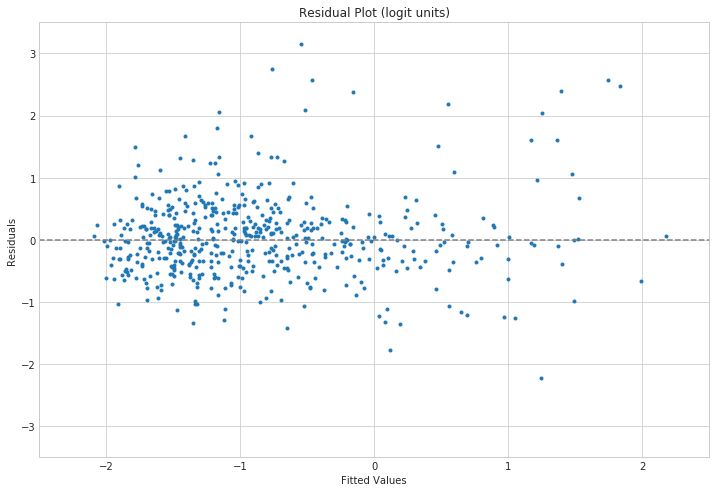

In [7]:
_predictions = logit(predictions[applicantsok])  # values are in logit units
_actual = logit(df['% SHSAT Testers'][applicantsok])  # values are in logit units

xs = _predictions
ys = _actual - _predictions  # residual

plt.figure(figsize=(12, 8))
plt.plot(xs, ys, '.')
plt.axhline(0.0, linestyle='--', color='gray')
plt.xlim(-2.5, 2.5)
plt.ylim(-3.5, 3.5)
plt.title("Residual Plot (logit units)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals");

In [8]:
mae = median_absolute_error(_actual, _predictions)
mse = mean_squared_error(_actual, _predictions)

print("Median Absolute Error:", mae)
print("Mean Squared Error:", mse)

Median Absolute Error: 0.34255265243940203
Mean Squared Error: 0.4347346053891031


The low `P>|z|` values indicates that the model is really good, the residual plot indicates a healthy fit and the model scores are what we expected, given the cross-validation results.

Below I make a plot for the less statistic-oriented folks. It compares the percentage of students that were expected to take SHSAT to the percentage of students that actually took SHSAT<sup>1</sup>.

<sub>1: Schools from 0 to 5 test takers were not included.</sub>

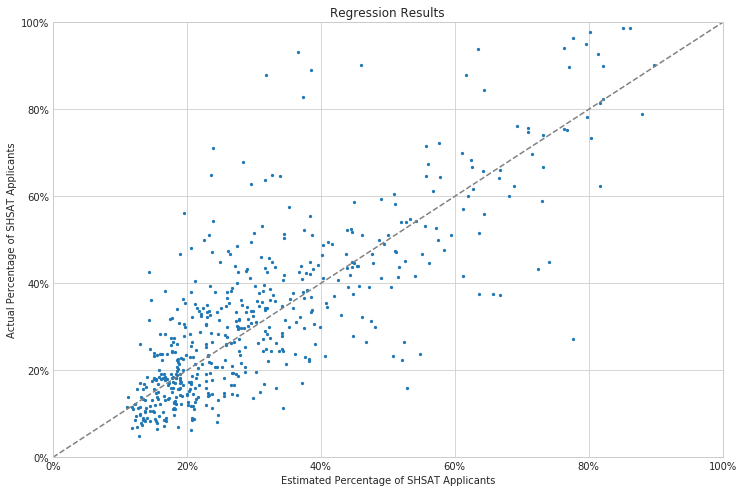

In [9]:
xs = predictions[applicantsok]
ys = df['% SHSAT Testers'][applicantsok]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(xs, ys, s=5)
ax.plot([0, 1], [0, 1], '--', c='gray')
ax.xaxis.set_major_formatter(plt.FuncFormatter("{:.0%}".format))
ax.yaxis.set_major_formatter(plt.FuncFormatter("{:.0%}".format))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Regression Results")
ax.set_xlabel("Estimated Percentage of SHSAT Applicants")
ax.set_ylabel("Actual Percentage of SHSAT Applicants");

Personally, I believe this is a good fit and everyone on Kaggle should use it. Kidding! I mean, it might probably be of good use to PASSNYC. :)

Below I will export the predicted probabilities to a nicer format.

In [10]:
df_export = predictions.to_frame()
# df_export.to_csv("expected_testers.csv")
df_export.head()

,Expected # SHSAT Testers
DBN,
01M034,0.150379
01M140,0.135216
01M184,0.692827
01M188,0.163353
01M301,0.188150


And it's done.

Some more things to do:

- Generate a table with predictions and gaps as a utility for PASSNYC
- Demonstrate the use of the table alongside an attractiveness score (or link some other kernels)
- Check if the gaps from 2017 are gonna still be relevant in 2018 (Central Harlem I call you)
- Try a different model with a little spice that has been in my mind
- Remember the dropped schools! I'm gonna create a model for each category of them
- Anything you post here VVV

See ya!

---

/home/andre/miniconda3/envs/passnyc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


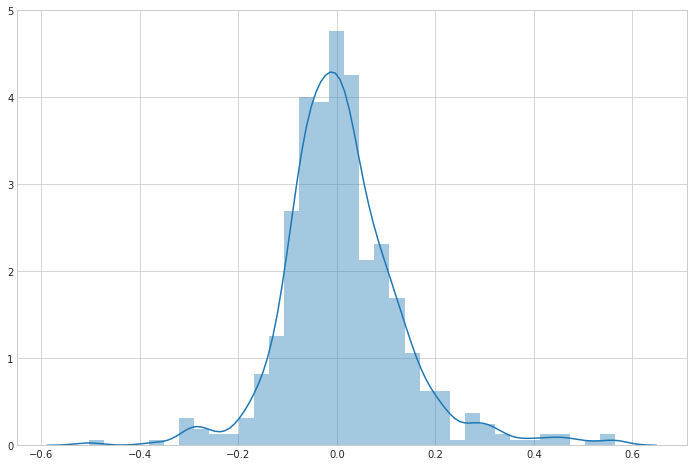

In [13]:
predictions = predictions[applicantsok]
actual = df['% SHSAT Testers'][applicantsok]
diffs = actual - predictions

plt.figure(figsize=(12, 8))
sns.distplot(diffs)

In [16]:
pd.Series(diffs).describe()

count    523.000000
mean       0.012272
std        0.121521
min       -0.503565
25%       -0.055217
50%        0.000500
75%        0.068954
max        0.564922
dtype: float64